<a href="https://colab.research.google.com/github/Chyproject/Sistem-Rekomendasi-Smartphone-/blob/main/Sistem_Rekomendasi_Smartphone_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.neighbors import NearestNeighbors
import pickle

# =========================
# LOAD DATASET
# =========================
df = pd.read_csv("cleaned_data.csv")








In [ ]:
# =========================
# PREPROCESSING
# =========================
features = [
    'price','rating','ram_gb','storage_gb','battery_mah',
    'fast_charge_w','screen_size_in','refresh_rate_hz',
    'rear_camera_max_mp','front_camera_mp',
    'VoLTE','NFC','ir_blaster',
    'os','chipset','display_type'
]

df = df[['model'] + features].dropna().reset_index(drop=True)

cat_cols = ['os','chipset','display_type']
num_cols = [c for c in features if c not in cat_cols]

scaler = MinMaxScaler()
num_scaled = scaler.fit_transform(df[num_cols])

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
cat_encoded = encoder.fit_transform(df[cat_cols])

X = np.hstack((num_scaled, cat_encoded))

In [ ]:
# =========================
# MODELING (KNN)
# =========================
knn = NearestNeighbors(
    n_neighbors=6,        # 1 diri sendiri + 5 rekomendasi
    metric='cosine'
)

knn.fit(X)

# Simpan model
with open("knn_model.pkl", "wb") as f:
    pickle.dump(knn, f)

In [ ]:
def accuracy_precision_at_k(model_hp, k=5):
    if model_hp not in df['model'].values:
        return None

    # Ambil spesifikasi target
    idx = df[df['model'] == model_hp].index[0]
    target_ram = df.loc[idx, 'ram_gb']
    target_storage = df.loc[idx, 'storage_gb']

    # Ambil rekomendasi
    rekom = rekomendasi_hp(model_hp, k)

    # Tentukan relevansi
    relevan = rekom[
        (rekom['ram_gb'] == target_ram) &
        (rekom['storage_gb'] == target_storage)
    ]

    accuracy = len(relevan) / k
    return accuracy



Tabel Precision@5:


,Model HP,Precision@5
0,oneplus 11 5g,0.4
1,realme 10 pro plus,0.2
2,samsung galaxy a15,NaN
3,xiaomi redmi note 12,0.2
4,vivo y35,0.6


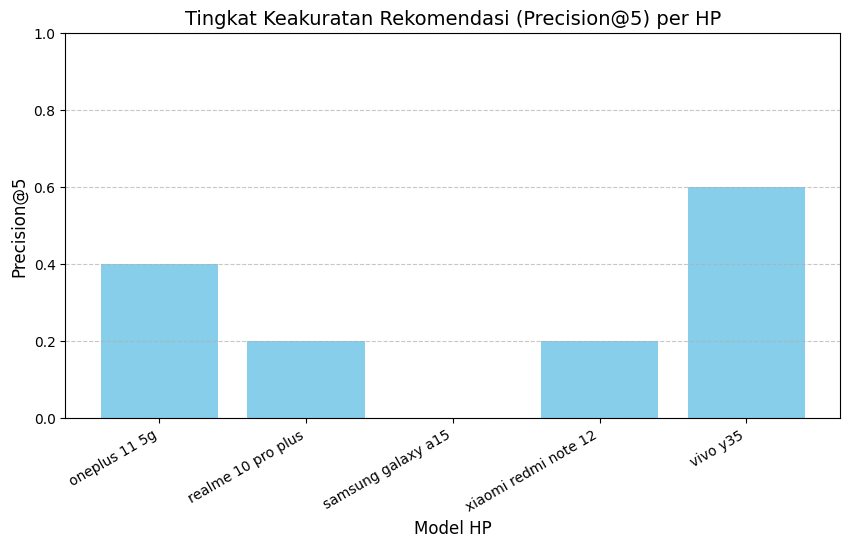

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =================================
# List HP untuk diuji
# =================================
hp_list = [
    "oneplus 11 5g",
    "realme 10 pro plus",
    "samsung galaxy a15",
    "xiaomi redmi note 12",
    "vivo y35"
]

# =================================
# Hitung Precision@5 untuk tiap HP
# =================================
results = []
for hp in hp_list:
    acc = accuracy_precision_at_k(hp, k=5)
    results.append({
        "Model HP": hp,
        "Precision@5": acc
    })

# =================================
# Buat DataFrame
# =================================
df_acc = pd.DataFrame(results)
print("Tabel Precision@5:")
display(df_acc)

# =================================
# Grafik Batang
# =================================
plt.figure(figsize=(10,5))
plt.bar(df_acc['Model HP'], df_acc['Precision@5'], color='skyblue')
plt.title('Tingkat Keakuratan Rekomendasi (Precision@5) per HP', fontsize=14)
plt.xlabel('Model HP', fontsize=12)
plt.ylabel('Precision@5', fontsize=12)
plt.ylim(0,1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=30, ha='right')
plt.show()


In [ ]:
# =========================
# REKOMENDASI BERDASARKAN HARGA
# =========================
def rekomendasi_hp_by_price(target_price, tolerance=1000, top_n=5):
    # Filter HP dengan price ± tolerance
    df_filtered = df[
        (df['price'] >= target_price - tolerance) &
        (df['price'] <= target_price + tolerance)
    ]

    if df_filtered.empty:
        return "Tidak ada HP dalam kisaran harga ini"

    # Urutkan berdasarkan rating tertinggi atau bisa diganti kriteria lain
    df_sorted = df_filtered.sort_values(by='rating', ascending=False).head(top_n)

    return df_sorted[['model','price','ram_gb','storage_gb','battery_mah','rear_camera_max_mp']].reset_index(drop=True)

# =========================
#  penggunaan
# =========================
target_price = 16499
rekom_price = rekomendasi_hp_by_price(target_price, tolerance=1000, top_n=5)
print(f"Rekomendasi HP sekitar harga {target_price}:")
print(rekom_price)


Rekomendasi HP sekitar harga 16499:
                         model  price  ram_gb  storage_gb  battery_mah  \
0        samsung galaxy m34 5g  16999       6           6       6000.0   
1        xiaomi redmi note 11s  15824       8           8       5000.0   
2            motorola moto g60  15999       6           6       6000.0   
3                  realme 9 4g  15999       8           8       5000.0   
4  xiaomi redmi note 10 pro 5g  16999       6           6       5000.0   

   rear_camera_max_mp  
0                64.0  
1               108.0  
2               108.0  
3               108.0  
4                64.0  
